In [3]:
import pandas as pd
import numpy as np
from lxml import html
from bs4 import BeautifulSoup
import datetime as dt

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdate

%matplotlib inline

In [192]:
mpl.rc('figure', figsize = (14, 10))
# Font size to 14
#mpl.rc('font', size = 18, family = 'sans', weight = 'normal')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Andale Mono']
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False, left = False)
# Remove grid lines
mpl.rc('axes', grid = False, facecolor = 'white')
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')


orange = "#f57912"
mediumturquoise = "#45cec8"
darkslateblue = "#284b7c"
darkslategray = "#394148"
tomato = "#f54d4d"
lavender = "#d1eefc"
orange = "#f8af03"
whitesmoke = "#eff2f5"
gainsboro = "#e3caef"

In [6]:
#ads = pd.read_html('MyActivity.html')


with open(r'MyActivity.html', "r") as f:
    page = f.read()

ads = BeautifulSoup(page, "html.parser")

In [7]:
actions = ads.find_all(class_ ="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1")
descriptions = ads.find_all(class_ ="content-cell mdl-cell mdl-cell--12-col mdl-typography--caption")

In [8]:
actions_list = []

for i in actions: 
    actions_list.append(i.get_text(separator = '<br>'))
    
descriptions_list = []

for j in descriptions: 
    descriptions_list.append(j.get_text(separator = '<br>'))

In [9]:
df = pd.DataFrame(dict(actions = actions_list, descriptions = descriptions_list))
# It's all identical so we can drop it
df.descriptions.value_counts()
df.drop('descriptions', axis = 1, inplace = True)

In [10]:
df.actions = df.actions.str.replace(',', '')
df.head()

,actions
0,Viewed Gmail ads<br>May 2 2019 9:49:39 PM CEST
1,Viewed Gmail ads<br>May 2 2019 6:11:47 PM CEST
2,Viewed Gmail ads<br>May 2 2019 4:55:31 PM CEST
3,Viewed Gmail ads<br>May 2 2019 8:11:06 AM CEST
4,Viewed Gmail ads<br>May 1 2019 1:08:18 PM CEST


In [11]:
df = df.actions.str.split(pat = '<br>', n = 2, expand = True)
df.columns = ['action', 'url', 'timestamp']
df.head()

,action,url,timestamp
0,Viewed Gmail ads,May 2 2019 9:49:39 PM CEST,None
1,Viewed Gmail ads,May 2 2019 6:11:47 PM CEST,None
2,Viewed Gmail ads,May 2 2019 4:55:31 PM CEST,None
3,Viewed Gmail ads,May 2 2019 8:11:06 AM CEST,None
4,Viewed Gmail ads,May 1 2019 1:08:18 PM CEST,None


In [12]:
for index, row in df.iterrows():
    if row.timestamp is None:
        row.timestamp = row.url
df['url'] = df.url.apply(lambda x: x if x.startswith('http') else np.nan)
df.timestamp = pd.to_datetime(df.timestamp)
df.head()

,action,url,timestamp
0,Viewed Gmail ads,NaN,2019-05-02 19:49:39
1,Viewed Gmail ads,NaN,2019-05-02 16:11:47
2,Viewed Gmail ads,NaN,2019-05-02 14:55:31
3,Viewed Gmail ads,NaN,2019-05-02 06:11:06
4,Viewed Gmail ads,NaN,2019-05-01 11:08:18


In [13]:
mapping ={'Viewed Gmail ads': 'Viewed', 'Visited\xa0': 'Viewed', 'Read\xa0': "Viewed",
       'Dismissed\xa0an ad': "Dismissed", 'Viewed\xa0an ad': 'Viewed', 'Clicked\xa0an ad': "Viewed"}

df['counter'] = 1
df.action = df.action.map(mapping)
df.action.value_counts()

Viewed       1220
Dismissed      51
Name: action, dtype: int64

In [14]:
byweek = df.groupby([pd.Grouper(key='timestamp', freq='m'), 'action']).counter.sum()\
        .reset_index().set_index('timestamp')

In [15]:
##for i in byweek.action.unique():
 #   byweek[byweek.action == i].plot()
 #   plt.show()

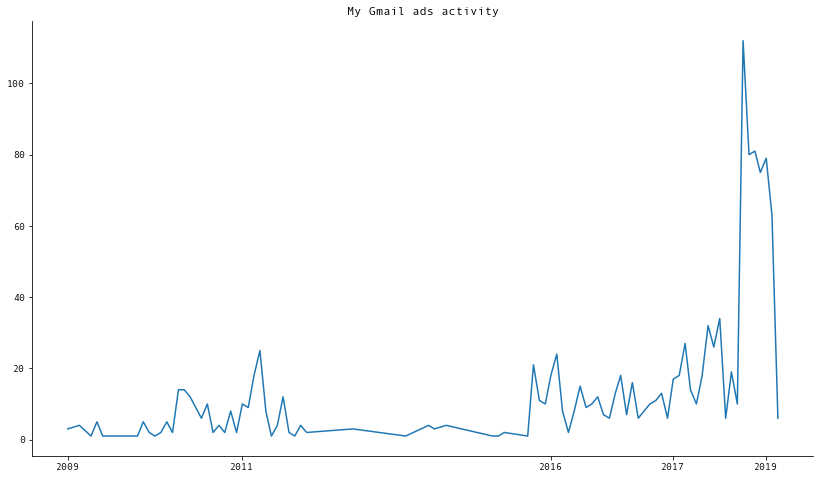

In [18]:
plt.figure(figsize = (14, 8))

ax = sns.lineplot(data = byweek[byweek.action == 'Viewed'].counter)
#ax = sns.lineplot(data = byweek[byweek.action == 'Visited'].counter)


plt.xticks(byweek.index[0::24])
#yearsFmt = mdate.DateFormatter('%Y-%m')
#ax.xaxis_date()
#ax.xaxis.set_major_formatter(yearsFmt)

ax.set_title("My Gmail ads activity")
plt.show()

In [68]:
# Construct necessary dataframes

byweeknew = byweek.loc['2016-12-31':'2019-04-30']
byweeknew = byweeknew.pivot(columns = 'action')
byweeknew.columns = ['Dismissed', 'Clicked']
#byweeknew.drop('Viewed', axis = 1, inplace = True)
#byweeknew['Total'] = byweeknew.sum(axis = 1)
byweeknew = byweeknew.iloc[0:-1] # Drop the last month

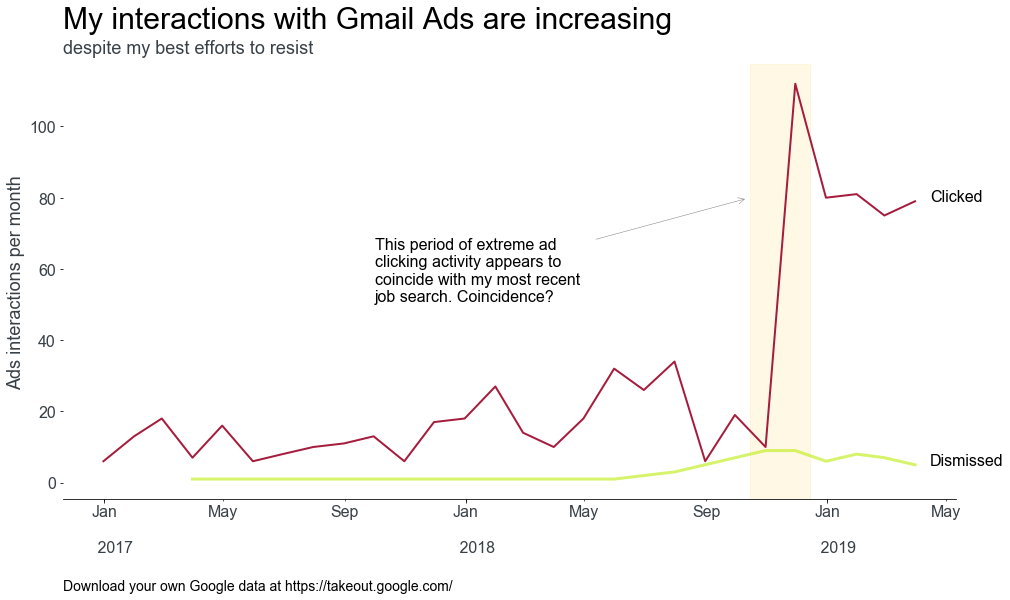

In [191]:
#fig = plt.figure()
plt.figure(figsize = (16, 8))


#ax = sns.lineplot(x = byweeknew.index, y = byweeknew.Visited, linewidth = 2, color = "#A61C3C", alpha = 0.4)
ax = sns.lineplot(x = byweeknew.index, y = byweeknew.Clicked, linewidth = 2, color = "#A61C3C", alpha = 1)
ax = sns.lineplot(x = byweeknew.index, y = byweeknew.Dismissed, linewidth = 3, color = "#BCED09", alpha = 0.6)
#ax = sns.lineplot(x = byweeknew.index, y = byweeknew.Total, linewidth = 3, color = "#4C5B5C", alpha = 1)


ax.axvspan('2018-10-15', '2018-12-15', alpha=0.2, color='#FADF7F')


#plt.xticks(new.index[0::30])

monthsFmt = mdate.DateFormatter('%b') 
yearsFmt = mdate.DateFormatter('\n\n     %Y')
ax.xaxis.set_minor_locator(mdate.MonthLocator(interval = 4))
ax.xaxis.set_major_locator(mdate.YearLocator())
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.tick_params(labelsize = 16, axis = 'both', which = 'both', labelcolor = darkslategray)

# Set major titles
plt.suptitle("My interactions with Gmail Ads are increasing", 
             y=0.98, 
             fontsize=30, 
             ha = 'left', 
             x = 0.125)
plt.title('despite my best efforts to resist', 
          y = 1.01, 
          fontsize=18, 
          loc = 'left', 
          color = darkslategray)

# Set axis titles
ax.set_xlabel("")
ax.set_ylabel("Ads interactions per month", 
              size = 18, 
              color = darkslategray)

# Label the lines
num=0
for i in byweeknew.values[-1]:
    name=byweeknew.columns[num]
    plt.text('2019-04-15', i, name, horizontalalignment='left', size=16, color='black')
    num+=1

# Annotate the period of increase
text = "This period of extreme ad \nclicking activity appears to \ncoincide with my most recent \njob search. Coincidence?"
ax.annotate(text, 
            xy=('2018-10-15', 80), 
            xytext=('2017-10-01', 50),
            arrowprops=dict(arrowstyle="->", 
                            linestyle="solid",
                            linewidth = 0.5,
                            color="grey",
                            shrinkA=10, 
                            shrinkB=5), 
            color = 'black', 
            size = 16, 
            ha = 'left', 
            va = 'bottom')

# Add subscript
subscript = "Download your own Google data at https://takeout.google.com/"

plt.figtext(x = 0, y = -0.2, 
        s = subscript, 
        ha='left', 
        va='center', 
        transform=ax.transAxes, 
        size = 14, 
        clip_on = True, in_layout = True)

plt.savefig('vasilikioti_gmail_ads.png', bbox_inches="tight")
plt.show()